Simple Algorithmic Trading Strategy

In [1]:
from alpha_vantage.timeseries import TimeSeries  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#1




In [2]:

class ScriptData:
    def fetch_intraday_data(self, stk):
        ts = TimeSeries(key=self.myKey)
        data, meta_data = ts.get_intraday(stk)

        self.map[stk] = data
        # return data

    def convert_intraday_data(self, stk):
        data = self.map[stk]
        data = pd.DataFrame(data).T
        data.columns=[ 'open',	'high'	, 'low' , 	'close' ,  'volume']
        data.index.name="timestamp"
        data = data.reset_index()
        
        data[['open','high','low','close']] = data[['open','high','low','close']].astype(float)
        data['volume'] = data['volume'].astype(int)
        
        self.map[stk] = data
        return data

        
    def __init__(self) -> None:
        self.map = dict()
        self.myKey = "Z8NVJC5M4WYK1JLH" 


    def __getitem__(self, stk):
        return (self.map[stk])

    def __setitem__(self, key, value):
        self.map[key] = value

    def __contains__(self, key):
        return key in self.map.keys()


In [3]:
script_data = ScriptData()
script_data.fetch_intraday_data('GOOGL')
script_data.convert_intraday_data('GOOGL')
script_data['GOOGL']

,timestamp,open,high,low,close,volume
0,2023-02-13 20:00:00,94.28,94.4000,94.2800,94.400,21749
1,2023-02-13 19:45:00,94.30,94.4700,94.2900,94.290,4524
2,2023-02-13 19:30:00,94.30,94.3900,94.2800,94.300,3308
3,2023-02-13 19:15:00,94.29,94.3000,94.2700,94.300,4382
4,2023-02-13 19:00:00,94.30,94.3000,94.2000,94.270,14263
...,...,...,...,...,...,...
95,2023-02-10 12:15:00,94.60,94.6513,94.2500,94.430,2322443
96,2023-02-10 12:00:00,94.99,95.1000,94.5800,94.605,1461925
97,2023-02-10 11:45:00,94.92,95.0100,94.6801,94.990,1397764
98,2023-02-10 11:30:00,95.19,95.3000,94.9100,94.920,1253697


In [4]:
'GOOGL' in script_data 

True

In [5]:
'AAPL' in script_data

False

#2

In [6]:
def indicator1(  df, timeperiod=5  ):
    
    lst = [np.nan]*(timeperiod-1)
    lst.extend([ df['close'][i-timeperiod:i].mean() for i  in range(timeperiod,df['close'].size+1)])
    
    indiframe = pd.DataFrame()
    indiframe['timestamp'] ,indiframe['indicator'] = df['timestamp'] ,lst
    
    return indiframe

              timestamp Action
0   2023-02-13 20:00:00    buy
1   2023-02-13 19:00:00   sell
2   2023-02-13 18:30:00    buy
3   2023-02-13 18:15:00   sell
4   2023-02-13 17:45:00    buy
5   2023-02-13 17:00:00   sell
6   2023-02-13 16:30:00    buy
7   2023-02-13 16:15:00   sell
8   2023-02-13 15:15:00    buy
9   2023-02-13 14:45:00   sell
10  2023-02-13 14:15:00    buy
11  2023-02-13 13:00:00   sell
12  2023-02-13 12:00:00    buy
13  2023-02-13 11:30:00   sell
14  2023-02-13 10:00:00    buy
15  2023-02-13 09:45:00   sell
16  2023-02-13 09:30:00    buy
17  2023-02-13 09:15:00   sell
18  2023-02-13 08:30:00    buy
19  2023-02-13 07:00:00   sell
20  2023-02-13 06:00:00    buy
21  2023-02-13 05:45:00   sell
22  2023-02-13 04:30:00    buy
23  2023-02-13 04:15:00   sell
24  2023-02-10 19:00:00    buy
25  2023-02-10 18:15:00   sell
26  2023-02-10 17:00:00    buy
27  2023-02-10 16:45:00   sell
28  2023-02-10 16:30:00    buy
29  2023-02-10 16:15:00   sell
30  2023-02-10 16:00:00    buy
31  2023

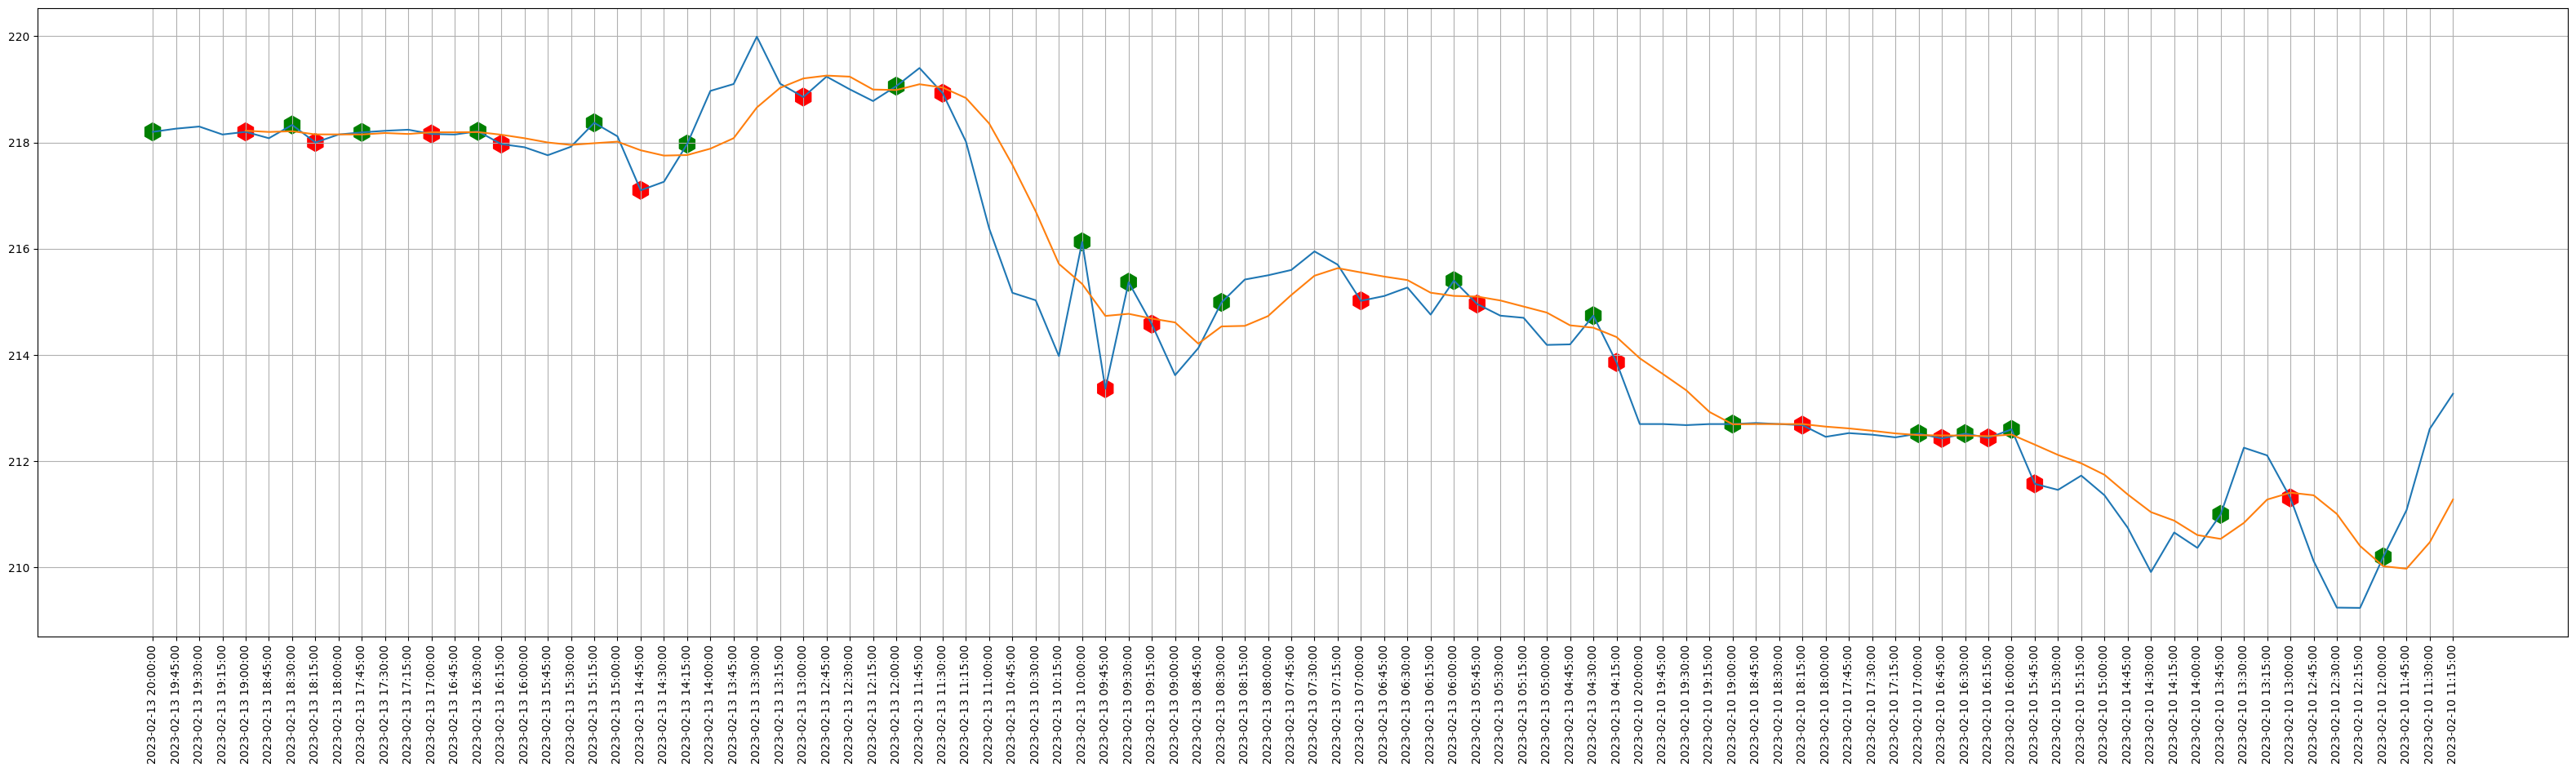

In [14]:
class Strategy:
    
    def __init__(self, stk):
            
         # Fetch intraday data using the ScriptData class
        script_data = ScriptData()
        script_data.fetch_intraday_data(stk)
        df = script_data.convert_intraday_data(stk)

        # Store closing price data and technical indicator data
        self.close_data = df['close']
        self.indicator_data = indicator1(df, timeperiod=5)

    def get_script_data(self):
        return self.close_data, self.indicator_data

    def get_signal(self):

        self.signal = pd.DataFrame()

        indi_data = self.indicator_data
        cls_data = self.close_data

        temp = 0

        for i in range(0, cls_data.size):
            action = 0 if indi_data.iloc[i]['indicator'] > cls_data.iloc[i] else 1

            if (action != temp):
                temp = action
                new_data = pd.DataFrame({'coor': cls_data.iloc[i],
                                         'timestamp': indi_data.iloc[i]['timestamp'],
                                         'Action': ["buy" if action else "sell"]})
                
                self.signal = pd.concat(
                    [self.signal, new_data], ignore_index=True)
                
        print( self.signal[['timestamp','Action']])

    def plot_action(self):
        
        plt.figure(figsize=(40, 10))
        plt.xticks(rotation=90)
        plt.grid()
        plt.plot(self.close_data)
        plt.plot(self.indicator_data['timestamp'],
                 self.indicator_data['indicator'])

        color = ['red' if i == 'sell' else 'green' for i in self.signal['Action']]
        plt.scatter(self.signal['timestamp'], self.signal['coor'], c=color ,marker='h',s = 250)
        print("_"*150," \nGreen : Purchase \n Red : Sell")


Strateg = Strategy('NVDA')
Strateg.get_signal()
Strateg.plot_action()
